# State estimation with unknown $\mathbf{A}$
State space model
\begin{align*}
    &\mathbf{x}_n = \mathbf{A}\mathbf{x}_{n-1} + \mathbf{n} \quad \mathbf{n} \sim \mathcal{N}(\mathbf{0}, \mathbf{I}\gamma_x^{-1}) \\
    &y_n = \mathbf{c}^\text{T}\mathbf{x}_n + v \quad v \sim \mathcal{N}(0, \gamma_y^{-1})
\end{align*}

or

\begin{align*}
     &p(\mathbf{x}_n\,|\,\mathbf{x}_{n-1},\mathbf{a},\gamma) = \mathcal{N}\left(\mathbf{x}_n \;\middle|\; \mathbf{A}\mathbf{x}_{n-1},  \gamma_y^{-1} \right)\\
    &p(y_n\,|\,\mathbf{x}_{n}) = \mathcal{N}\left(y_n \;\middle|\;\mathbf{c}^\text{T}\mathbf{x}_n, \epsilon \right)
\end{align*}

where
\begin{align*}
    &\mathbf{x}_n = (x_n, x_{n-1}, \dots, x_{n-p+1})^\text{T} \quad \mathbf{x}_{n-1} = (x_{n-1}, x_{n-2}, \dots, x_{n-p})^\text{T} 
    \\ \\
    &\mathbf{A} = 
    \begin{bmatrix}
        a_1 & a_2 & a_3 & \dots & a_p \\
        1 & 0 & 0 & \dots & 0 \\ 
        0 & 1 & 0 & \dots & 0 \\   
        \vdots & \vdots & \vdots & \ddots & \vdots \\
        0 & 0 & 0 & \dots & 0
    \end{bmatrix}
    =
    \begin{bmatrix}
         \mathbf{a}^\text{T} \\
         \mathbf{I}_{p-1} \quad \mathbf{0}
    \end{bmatrix}
    \\ \\
    &\mathbf{I} = \mathbf{I}_p = 
    \begin{bmatrix}
        1 & 0 & 0 & \dots & 0 \\ 
        0 & 1 & 0 & \dots & 0 \\   
        \vdots & \vdots & \vdots & \ddots & \vdots \\
        0 & 0 & 0 & \dots & 1
    \end{bmatrix} \\
\end{align*}

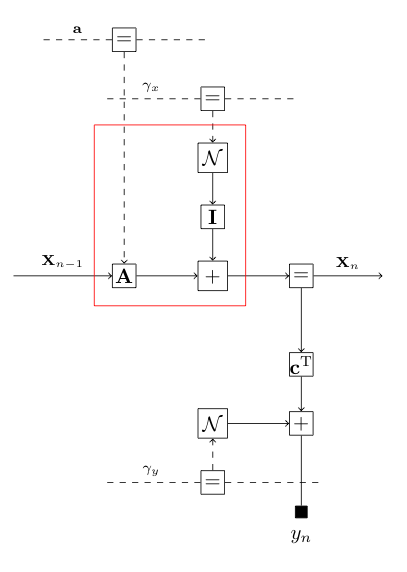

In [1]:
using Images
img = load("../ffgs/HAR-online.png")

The central quantity of our interest is a joint estimation of the AR coefficients $\mathbf{a}$ and states $\mathbf{x}_n$, while setting noises' precision $\gamma_x=1$, $\gamma_y=1/2$.

In [1]:
using ProgressMeter
using Revise
using ForneyLab
include( "../AR-node/autoregression.jl")
include("../AR-node/rules_prototypes.jl")
include("../AR-node/vmp_rules.jl")
# helpers for evaluation of the model
include("../helpers/functions.jl")
# module to generate data for AR
include("../data/ARdata.jl")
import Main.ARdata: use_data, generate_data
import LinearAlgebra.I, LinearAlgebra.Symmetric
import ForneyLab: unsafeCov, unsafeMean, unsafePrecision

In [2]:
ARorder = 10 # order of AR model
diagAR(dim) = Matrix{Float64}(I, dim, dim)
x = []
# AR data
a_w = 1.0; b_w = 1.0
process_noise = b_w/a_w
coefs, x = generate_data(1000, ARorder, 1, noise_variance=process_noise)
# Observations
measurement_noise = 2.0
y = [xi[1] + sqrt(measurement_noise)*randn() for xi in x[ARorder:end]]

991-element Array{Float64,1}:
  2.287137918090446  
 -0.7630517984057374 
 -1.1323890974511612 
  0.478147133208581  
 -0.2134835856499433 
 -1.8379885777463956 
  1.2114767715661934 
 -3.2512794627772887 
  0.07605900083235884
 -0.6453192849979893 
 -2.697642428637236  
 -1.4731373332527142 
  0.37664946486734885
  ⋮                  
  0.7824571995751672 
 -0.8679958462558117 
  0.9536621921287914 
 -0.3766473737308824 
  0.2484068621163495 
 -0.9025118342061398 
  0.8843560515279917 
  1.1882112943157082 
 -0.9046906231261536 
 -0.36949823743394816
  1.9077522913718379 
  1.5577773283991796 

In [3]:
ARorder = 10
# Building the model
g = FactorGraph()

# declare priors as random variables
@RV m_x_t_prev
@RV w_x_t_prev
@RV m_a_t
@RV w_a_t
@RV m_y_t

@RV a ~ GaussianMeanPrecision(m_a_t, w_a_t)
@RV x_t_prev ~ GaussianMeanPrecision(m_x_t_prev, w_x_t_prev)
@RV w ~ Gamma(a_w, b_w)
@RV x_t = AR(a, x_t_prev, w)
c = zeros(ARorder); c[1] = 1.0
@RV y_t ~ GaussianMeanPrecision(m_y_t, measurement_noise^-1)
DotProduct(y_t, c, x_t)

# Placeholders for prior
placeholder(m_x_t_prev, :m_x_t_prev, dims=(ARorder,))
placeholder(w_x_t_prev, :w_x_t_prev, dims=(ARorder, ARorder))
placeholder(m_a_t, :m_a_t, dims=(ARorder,))
placeholder(w_a_t, :w_a_t, dims=(ARorder, ARorder))

# Placeholder for data
placeholder(m_y_t, :m_y_t)

ForneyLab.draw(g)

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.40.1 (20161225.0304)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 4751744370032124131 -->
 
 4751744370032124131 
 
 𝒩 
 gaussianmeanprecision_2 
 
<!-- 4932810428687180929 -->
 
 4932810428687180929 
 
 placeholder_m_y_t 
 
<!-- 11903422925276357420 -->
 
 11903422925276357420 
 
 𝒩 
 gaussianmeanprecision_3 
 
<!-- 4932810428687180929--11903422925276357420 -->
 
 4932810428687180929--11903422925276357420 
 
 m_y_t 
 2 m 
 1 out 
 
<!-- 14257208265398065011 -->
 
 14257208265398065011 
 
 clamp_2 
 
<!-- 9249290854904572512 -->
 
 9249290854904572512 
 
 placeholder_m_x_t_prev 
 
<!-- 9249290854904572512--4751744370032124131 -->
 
 9249290854904572512--4751744370032124131 
 
 m_x_t_prev 
 2 m 
 1 out 
 
<!-- 9901533582438024456 -->
 
 9901533582438024456 
 
 placeholder_w_x_t_prev 
 
<!-- 9901533582438024456--4751744370032124131 -->
 
 9901533582438024456--4751744370032124131 
 
 w_x_t_prev 
 3 w 
 1 out 
 
<!-- 15438931920119411317 -->
 
 15438931920119411317 
 
 clamp_3 
 
<!-- 11903422925276357420--15438931920119411317 -->
 
 11903422925276357420--15438931920119411317 
 
 clamp_3 
 1 out 
 3 w 
 
<!-- 6795555413179751872 -->
 
 6795555413179751872 
 
 dot 
 dotproduct_1 
 
<!-- 6795555413179751872--11903422925276357420 -->
 
 6795555413179751872--11903422925276357420 
 
 y_t 
 1 out 
 1 out 
 
<!-- 10734617724845786966 -->
 
 10734617724845786966 
 
 clamp_4 
 
<!-- 6795555413179751872--10734617724845786966 -->
 
 6795555413179751872--10734617724845786966 
 
 clamp_4 
 1 out 
 2 in1 
 
<!-- 13520291297001703415 -->
 
 13520291297001703415 
 
 Autoregression 
 autoregression_1 
 
<!-- 6795555413179751872--13520291297001703415 -->
 
 6795555413179751872--13520291297001703415 
 
 x_t 
 1 out 
 3 in2 
 
<!-- 17554158127100432551 -->
 
 17554158127100432551 
 
 placeholder_m_a_t 
 
<!-- 15207683622121001861 -->
 
 15207683622121001861 
 
 𝒩 
 gaussianmeanprecision_1 
 
<!-- 17554158127100432551--15207683622121001861 -->
 
 17554158127100432551--15207683622121001861 
 
 m_a_t 
 2 m 
 1 out 
 
<!-- 11674081543584723781 -->
 
 11674081543584723781 
 
 clamp_1 
 
<!-- 14875064170646048559 -->
 
 14875064170646048559 
 
 placeholder_w_a_t 
 
<!-- 14875064170646048559--15207683622121001861 -->
 
 14875064170646048559--15207683622121001861 
 
 w_a_t 
 3 w 
 1 out 
 
<!-- 13520291297001703415--4751744370032124131 -->
 
 13520291297001703415--4751744370032124131 
 
 x_t_prev 
 1 out 
 2 x 
 
<!-- 13520291297001703415--15207683622121001861 -->
 
 13520291297001703415--15207683622121001861 
 
 a 
 1 out 
 3 a 
 
<!-- 15773721704719874103 -->
 
 15773721704719874103 
 
 Gam 
 gamma_1 
 
<!-- 13520291297001703415--15773721704719874103 -->
 
 13520291297001703415--15773721704719874103 
 
 w 
 1 out 
 4 W 
 
<!-- 15773721704719874103--14257208265398065011 -->
 
 15773721704719874103--14257208265398065011 
 
 clamp_2 
 1 out 
 3 b 
 
<!-- 15773721704719874103--11674081543584723781 -->
 
 15773721704719874103--11674081543584723781 
 
 clamp_1 
 1 out 
 2 a

In [4]:
# Specify recognition factorization
q = RecognitionFactorization(a, x_t, ids=[:A :X_t])

# Generate the variational update algorithms for each recognition factor
algo = variationalAlgorithm(q)

# Load algorithms
eval(Meta.parse(algo))

stepX_t! (generic function with 3 methods)

In [16]:
# Define values for prior statistics
m_a_0 = 1.0*randn(ARorder)
w_a_0 = (0.01*diagAR(ARorder))
m_x_prev_0 = 0.0*randn(ARorder)
w_x_prev_0 = (0.001*diagAR(ARorder))

# Storage
m_x_prev = Vector{Vector{Float64}}(undef, length(y))
w_x_prev = Vector{Array{Float64, 2}}(undef, length(y))
m_a = Vector{Vector{Float64}}(undef, length(y))
w_a = Vector{Array{Float64, 2}}(undef, length(y))

# Inits
m_x_t_prev_min = m_x_prev_0
w_x_t_prev_min = w_x_prev_0
m_a_t_min = m_a_0
w_a_t_min = w_a_0;

In [17]:
marginals = Dict()
# VMP iterations
n_its = 10

# Storage for estimations
# FIXME: redundant
estimations = []
# Storage for MSE of test set
MSEs = []
window = 10
# making first dummy estimation
push!(estimations, m_a_t_min'm_x_t_prev_min)
p = Progress(length(y), 1, "Observed ")
for t in 1:length(y)
    if mod(t, window) == 0
        push!(MSEs, mse(y[t-window+1:t], estimations[t-window+1:t]))
    end
    update!(p, t)
    marginals[:a] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=m_a_t_min, w=w_a_t_min)
    marginals[:x_t_prev] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=m_x_t_prev_min, w=w_x_t_prev_min)
    marginals[:w] = ProbabilityDistribution(Univariate, Gamma, a=a_w, b=b_w)
    global m_x_t_prev_min, w_x_t_prev_min, m_a_t_min, w_a_t_min

    for i = 1:n_its
        data = Dict(:m_y_t => y[t],
                    :m_a_t => m_a_t_min,
                    :w_a_t => w_a_t_min,
                    :m_x_t_prev => m_x_t_prev_min,
                    :w_x_t_prev => w_x_t_prev_min)
        stepX_t!(data, marginals)
        stepA!(data, marginals)
        m_a[t] = unsafeMean(marginals[:a])
        w_a[t] = unsafePrecision(marginals[:a])
        m_x_prev[t] = unsafeMean(marginals[:x_t])
        w_x_prev[t] = unsafePrecision(marginals[:x_t])
        m_a_t_min = m_a[t]
        w_a_t_min = w_a[t]
        m_x_t_prev_min = m_x_prev[t]
        w_x_t_prev_min = w_x_prev[t]
    end
    push!(estimations, m_x_prev[t][1])
end

Observed 100%|██████████████████████████████████████████| Time: 0:00:02


In [18]:
# MSE analysis
from = 1
estimated = [x[1] for x in m_x_prev[from:end]]
real = [x[1] for x in x[ARorder:end]]
noise = [y[1] for y in y[from:end]]

println("Δ(estimated, real)=", mse(estimated, real))
println("Δ(estimated, noise)=", mse(estimated, noise))
println("Δ(noise, actual)=", mse(noise, real))

Δ(estimated, real)=0.9380636945632372
Δ(estimated, noise)=1.644216590492712
Δ(noise, actual)=2.1211304032703144


In [9]:
using Plots

scale = 1.0 # scale for the variance
v_x = [v_x[1]^-1 for v_x in w_x_prev[1:end]] # variances of estimated state
toshow = 10 # number of points to plot at once

anim = @animate for i in 1:length(estimated)-toshow
    s = plot(xticks = i:div(toshow, 2):i+toshow);
    ylims!(minimum(noise) - .1, maximum(noise) + .1);
    scatter!(collect(i:i+toshow), noise[i:i+toshow], label="noisy observations", 
            markershape = :xcross, markeralpha = 0.6,
            markersize = 2)
    
    plot!(collect(i:i+toshow), [estimated[i:i+toshow], estimated[i:i+toshow]], fillrange=[estimated[i:i+toshow] -
          scale .* sqrt.(v_x[i:i+toshow]), estimated[i:i+toshow] + scale .* sqrt.(v_x[i:i+toshow])],
          linestyle=:dash, linewidth = 2,
          color=:black,
          fillalpha = 0.2,
          fillcolor = :red,
          label="inferred")
    
    plot!(collect(i:i+toshow), real[i:i+toshow], color = :magenta, linewidth = 1.0, label="real state")
end

Animation("/var/folders/jn/1xv7kskx42v_97gx1xd8y_g40000gq/T/tmphvUWAG", ["000001.png", "000002.png", "000003.png", "000004.png", "000005.png", "000006.png", "000007.png", "000008.png", "000009.png", "000010.png"  …  "000972.png", "000973.png", "000974.png", "000975.png", "000976.png", "000977.png", "000978.png", "000979.png", "000980.png", "000981.png"])

In [10]:
gif(anim, "../gifs/KMPstate.gif", fps = 10)

┌ Info: Saved animation to 
│   fn = /Users/albertpod/Documents/Julia/VariationalBayes/gifs/KMPstate.gif
└ @ Plots /Users/albertpod/.julia/packages/Plots/gylTh/src/animation.jl:90


Plots.AnimatedGif("/Users/albertpod/Documents/Julia/VariationalBayes/gifs/KMPstate.gif")

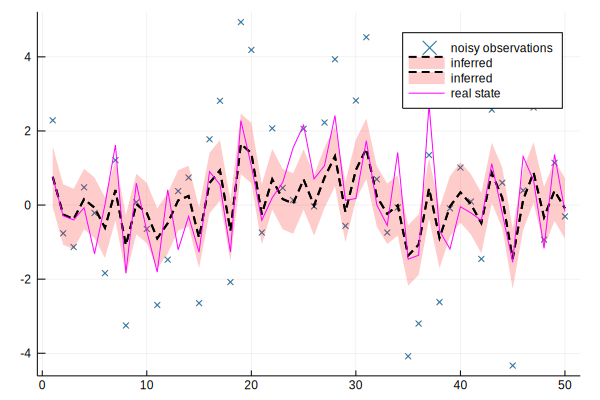

In [12]:
# Plotting
using Plots
upto = 50 # limit for building a graph
scale = 1.0 # scale for the variance
v_x = [v_x[1]^-1 for v_x in w_x_prev[1:end]] # variances of estimated state
scatter(noise[1:upto], label="noisy observations", 
        markershape = :xcross, markeralpha = 0.6,
        markersize = 2)
plot!([estimated[1:upto], estimated[1:upto]], fillrange=[estimated[1:upto] -
      scale .* sqrt.(v_x[1:upto]), estimated[1:upto] +
      scale .* sqrt.(v_x[1:upto])],
      linestyle=:dash,linewidth = 2,
      color=:black,
      fillalpha = 0.2,
      fillcolor = :red,
      label=["inferred", "inferred"])
plot!(real[1:upto], color = :magenta, linewidth = 1.0, label="real state")

In [20]:
# Plotting MSE
anim = @animate for i in 1:length(MSEs)
    s = plot()
    ylims!(minimum(MSEs) - 1, maximum(MSEs) + 1)
    xlims!(1, length(MSEs))
    plot!(collect(1:i), MSEs[1:i], xlabel="observation", ylabel="MSE", label="")
end;

In [21]:
gif(anim, "../gifs/MSE_evo_state.gif", fps = 100)

┌ Info: Saved animation to 
│   fn = /Users/albertpod/Documents/Julia/VariationalBayes/gifs/MSE_evo_state.gif
└ @ Plots /Users/albertpod/.julia/packages/Plots/gylTh/src/animation.jl:90


Plots.AnimatedGif("/Users/albertpod/Documents/Julia/VariationalBayes/gifs/MSE_evo_state.gif")

In [19]:
MSEs

99-element Array{Any,1}:
 3.081101852811972 
 7.526760299760279 
 4.241710706350949 
 5.1501803945473315
 4.777228335102928 
 3.9103191313620664
 4.189424861029165 
 3.514478168100389 
 4.0629705394171625
 3.771981428457953 
 5.704051899202719 
 2.32385231556676  
 5.501329622106684 
 ⋮                 
 1.9207978217827566
 3.376363872735303 
 3.232158197989532 
 2.962815772801915 
 2.3830209332146373
 2.2567239599350293
 2.8697145828286583
 3.2495437474330435
 6.944778481293133 
 7.279353635208078 
 3.0478280037557686
 1.2373808089626326